<a href="https://colab.research.google.com/github/szyxxx/MachineLearning-TelkomUniversity/blob/main/AXELDAVID_1103210017_TK4504_SKLEARN_CLUSTERING_MALL_CUSTOMERS_KMEANS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Axel David<br>
1103210017<br>
SKLearn Clustering<br>


# Import Library

In [242]:
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import pairwise_distances_argmin
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from google.colab import drive
import zipfile

# Import Dataset

In [243]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [244]:
! chmod 600 /content/drive/MyDrive/ColabNotebooks/kaggle_conf/kaggle.json

In [245]:
! KAGGLE_CONFIG_DIR=/content/drive/MyDrive/ColabNotebooks/kaggle_conf/ kaggle datasets download -d shwetabh123/mall-customers

mall-customers.zip: Skipping, found more recently modified local copy (use --force to force download)


In [246]:
zip_file = zipfile.ZipFile('/content/drive/MyDrive/ColabNotebooks/dataset/mall-customers.zip','r')
zip_file.extractall('/content/drive/MyDrive/ColabNotebooks/dataset/')

# Informasi Dataset

In [247]:
df = pd.read_csv("/content/drive/MyDrive/ColabNotebooks/dataset/Mall_Customers.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Genre                   200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [248]:
df.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [249]:
df.tail()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18
199,200,Male,30,137,83


In [250]:
df.rename(columns={'Genre': 'Gender'}, inplace=True)
df = pd.get_dummies(df, columns=['Gender'])
df['Gender'] = df['Gender_Male'].astype(int)

In [251]:
df.dtypes

CustomerID                int64
Age                       int64
Annual Income (k$)        int64
Spending Score (1-100)    int64
Gender_Female              bool
Gender_Male                bool
Gender                    int64
dtype: object

<h2>1. Clustering With KMeans</h2>

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


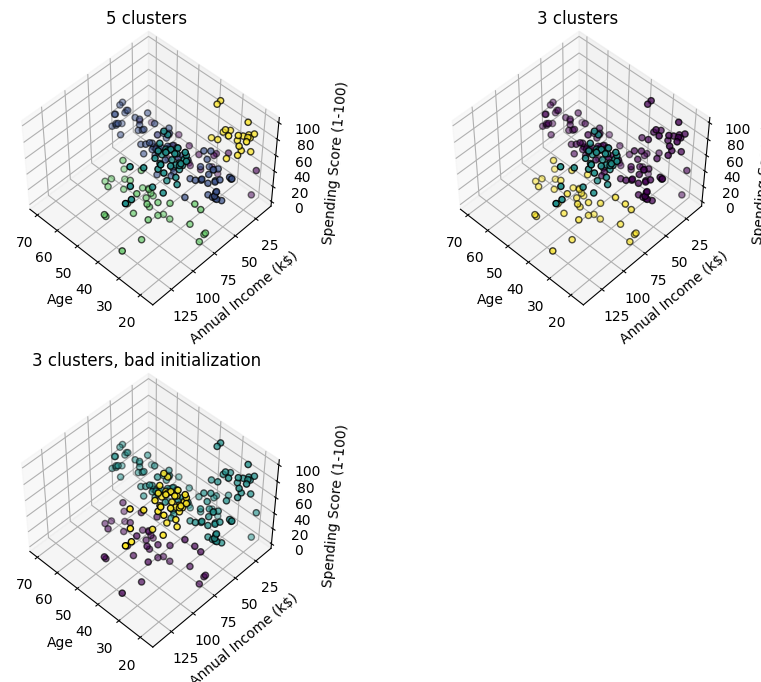

In [252]:
X = df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Gender']].values

estimators = [
    ("k_means_custom_5", KMeans(n_clusters=5)),
    ("k_means_custom_3", KMeans(n_clusters=3)),
    ("k_means_custom_bad_init", KMeans(n_clusters=3, n_init=1, init="random")),
]

fig = plt.figure(figsize=(10, 8))
titles = ["5 clusters", "3 clusters", "3 clusters, bad initialization"]
for idx, ((name, est), title) in enumerate(zip(estimators, titles), 1):
    ax = fig.add_subplot(2, 2, idx, projection="3d", elev=48, azim=134)
    est.fit(X)
    labels = est.labels_

    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=labels.astype(float), edgecolor="k")

    ax.set_xlabel("Age")
    ax.set_ylabel("Annual Income (k$)")
    ax.set_zlabel("Spending Score (1-100)")
    ax.set_title(title)

plt.subplots_adjust(wspace=0.25, hspace=0.25)
plt.show()

<h2>2. Low-level Parralelism - Comparison of Various Initialization in Terms of Runtime and Results Quality</h2>

In [253]:
df_clustering = df

In [254]:
df_clustering.columns

Index(['CustomerID', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)',
       'Gender_Female', 'Gender_Male', 'Gender'],
      dtype='object')

In [255]:
df_clustering.drop(['CustomerID', 'Gender'], axis=1, inplace=True)

# Normalisasi df_clustering menggunakan StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_clustering)

print("Dataset dimensions:", df_clustering.shape)

print(82 * "_")
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")

# KMeans dengan k-means++ initialization
t0 = time.time()
kmeans = KMeans(init="k-means++", n_clusters=5, n_init=4, random_state=0)
estimator = make_pipeline(StandardScaler(), kmeans).fit(scaled_data)
fit_time = time.time() - t0
inertia = estimator[-1].inertia_
metrics_scores = [
    metrics.homogeneity_score(estimator[-1].labels_, estimator[-1].labels_),
    metrics.completeness_score(estimator[-1].labels_, estimator[-1].labels_),
    metrics.v_measure_score(estimator[-1].labels_, estimator[-1].labels_),
    metrics.adjusted_rand_score(estimator[-1].labels_, estimator[-1].labels_),
    metrics.adjusted_mutual_info_score(estimator[-1].labels_, estimator[-1].labels_),
    metrics.silhouette_score(scaled_data, estimator[-1].labels_, metric="euclidean", sample_size=300),
]
results = ["k-means++", fit_time, inertia] + metrics_scores
formatter_result = "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
print(formatter_result.format(*results))

# KMeans dengan random initialization
t0 = time.time()
kmeans = KMeans(init="random", n_clusters=5, n_init=4, random_state=0)
estimator = make_pipeline(StandardScaler(), kmeans).fit(scaled_data)
fit_time = time.time() - t0
inertia = estimator[-1].inertia_
metrics_scores = [
    metrics.homogeneity_score(estimator[-1].labels_, estimator[-1].labels_),
    metrics.completeness_score(estimator[-1].labels_, estimator[-1].labels_),
    metrics.v_measure_score(estimator[-1].labels_, estimator[-1].labels_),
    metrics.adjusted_rand_score(estimator[-1].labels_, estimator[-1].labels_),
    metrics.adjusted_mutual_info_score(estimator[-1].labels_, estimator[-1].labels_),
    metrics.silhouette_score(scaled_data, estimator[-1].labels_, metric="euclidean", sample_size=300),
]
results = ["random", fit_time, inertia] + metrics_scores
print(formatter_result.format(*results))

# KMeans dengan PCA-based initialization
t0 = time.time()
pca = PCA(n_components=5).fit(scaled_data)
kmeans = KMeans(init=pca.components_, n_clusters=5, n_init=1)
estimator = make_pipeline(StandardScaler(), kmeans).fit(scaled_data)
fit_time = time.time() - t0
inertia = estimator[-1].inertia_
metrics_scores = [
    metrics.homogeneity_score(estimator[-1].labels_, estimator[-1].labels_),
    metrics.completeness_score(estimator[-1].labels_, estimator[-1].labels_),
    metrics.v_measure_score(estimator[-1].labels_, estimator[-1].labels_),
    metrics.adjusted_rand_score(estimator[-1].labels_, estimator[-1].labels_),
    metrics.adjusted_mutual_info_score(estimator[-1].labels_, estimator[-1].labels_),
    metrics.silhouette_score(scaled_data, estimator[-1].labels_, metric="euclidean", sample_size=300),
]
results = ["PCA-based", fit_time, inertia] + metrics_scores
print(formatter_result.format(*results))

print(82 * "_")


Dataset dimensions: (200, 5)
__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.010s	331	1.000	1.000	1.000	1.000	1.000	0.346
random   	0.020s	331	1.000	1.000	1.000	1.000	1.000	0.346
PCA-based	0.004s	420	1.000	1.000	1.000	1.000	1.000	0.305
__________________________________________________________________________________


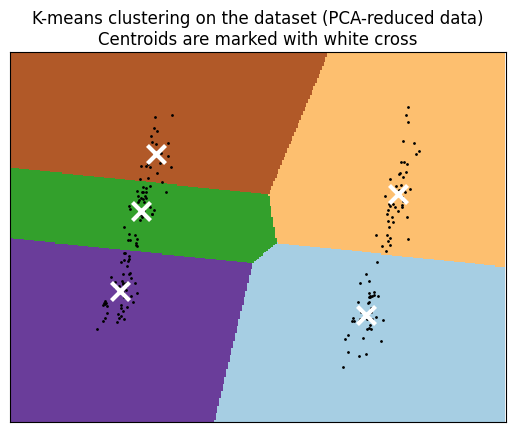

In [256]:
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)

kmeans = KMeans(init="k-means++", n_clusters=5, n_init=4)
kmeans.fit(reduced_data)

h = 0.02

x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)

centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on the dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

<h2>3. Mini Batch K-Means</h2>


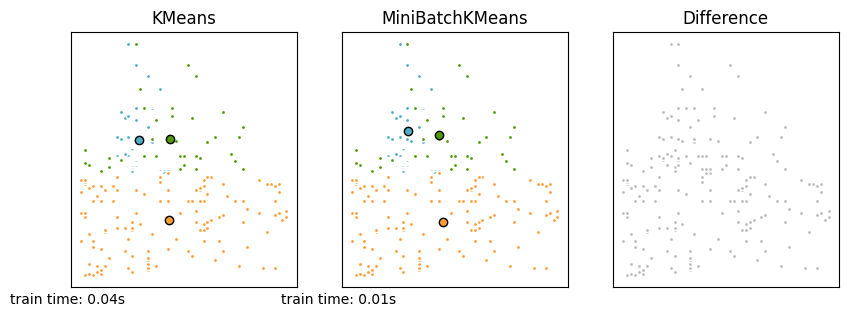

In [257]:
X = df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].values

# KMeans
k_means = KMeans(init="k-means++", n_clusters=3, n_init=10)
t0 = time.time()
k_means.fit(X)
t_batch = time.time() - t0
k_means_cluster_centers = k_means.cluster_centers_
k_means_labels = pairwise_distances_argmin(X, k_means_cluster_centers)

# MiniBatchKMeans
batch_size = 45
mbk = MiniBatchKMeans(
    init="k-means++",
    n_clusters=3,
    batch_size=batch_size,
    n_init=10,
    max_no_improvement=10,
    verbose=0,
)
t0 = time.time()
mbk.fit(X)
t_mini_batch = time.time() - t0
order = pairwise_distances_argmin(k_means_cluster_centers, mbk.cluster_centers_)
mbk_means_cluster_centers = mbk.cluster_centers_[order]
mbk_means_labels = pairwise_distances_argmin(X, mbk_means_cluster_centers)

fig = plt.figure(figsize=(8, 3))
fig.subplots_adjust(left=0.02, right=0.98, bottom=0.05, top=0.9)
colors = ["#4EACC5", "#FF9C34", "#4E9A06"]

# KMeans
ax = fig.add_subplot(1, 3, 1)
for k, col in zip(range(3), colors):
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    ax.plot(X[my_members, 0], X[my_members, 1], "w", markerfacecolor=col, marker=".")
    ax.plot(
        cluster_center[0],
        cluster_center[1],
        "o",
        markerfacecolor=col,
        markeredgecolor="k",
        markersize=6,
    )
ax.set_title("KMeans")
ax.set_xticks(())
ax.set_yticks(())
plt.text(0, 0, "train time: %.2fs" % t_batch)

# MiniBatchKMeans
ax = fig.add_subplot(1, 3, 2)
for k, col in zip(range(3), colors):
    my_members = mbk_means_labels == k
    cluster_center = mbk_means_cluster_centers[k]
    ax.plot(X[my_members, 0], X[my_members, 1], "w", markerfacecolor=col, marker=".")
    ax.plot(
        cluster_center[0],
        cluster_center[1],
        "o",
        markerfacecolor=col,
        markeredgecolor="k",
        markersize=6,
    )
ax.set_title("MiniBatchKMeans")
ax.set_xticks(())
ax.set_yticks(())
plt.text(0, 0, "train time: %.2fs" % t_mini_batch)

different = mbk_means_labels == 4
ax = fig.add_subplot(1, 3, 3)

for k in range(3):
    different += (k_means_labels == k) != (mbk_means_labels == k)

identical = np.logical_not(different)
ax.plot(X[identical, 0], X[identical, 1], "w", markerfacecolor="#bbbbbb", marker=".")
ax.plot(X[different, 0], X[different, 1], "w", markerfacecolor="m", marker=".")
ax.set_title("Difference")
ax.set_xticks(())
ax.set_yticks(())

plt.show()